# Formation Energy Prediction using *Meredig 2014* Descriptors

This notebook uses the method from [Meredig 2014](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.094104) to predict formation energy of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.descriptors import composition_features as cp
from matminer.descriptors.data import MagpieData
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~4500 compounds with data originally from the Inorganic Crystal Structures Database (ICSD).

In [2]:
training_set = pd.read_csv("datasets/meredig_binary_hull.data", sep=" ")
training_set = training_set.append(pd.read_csv("datasets/meredig_stable_ternary.data", sep=" "))
training_set

,composition,delta_e
0,ReRu0,0.000000
1,Re0.94444444Ru0.05555556,-0.013210
2,Re0.88888889Ru0.11111111,-0.026419
3,Re0.83333333Ru0.16666667,-0.039629
4,Re0.77777778Ru0.22222222,-0.052839
5,Re0.72222222Ru0.27777778,-0.057242
6,Re0.66666667Ru0.33333333,-0.052839
7,Re0.61111111Ru0.38888889,-0.048436
8,Re0.55555556Ru0.44444444,-0.044032
9,Re0.5Ru0.5,-0.039629


### Create PyMatGen Composition objects
The MatMiner featurizer takes PyMatGen composition objects as inputs

In [3]:
comp_objects = [Composition(comp) for comp in training_set["composition"]]
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,composition,delta_e,comp_obj
0,ReRu0,0.000000,(Re)
1,Re0.94444444Ru0.05555556,-0.013210,"(Re, Ru)"
2,Re0.88888889Ru0.11111111,-0.026419,"(Re, Ru)"
3,Re0.83333333Ru0.16666667,-0.039629,"(Re, Ru)"
4,Re0.77777778Ru0.22222222,-0.052839,"(Re, Ru)"
5,Re0.72222222Ru0.27777778,-0.057242,"(Re, Ru)"
6,Re0.66666667Ru0.33333333,-0.052839,"(Re, Ru)"
7,Re0.61111111Ru0.38888889,-0.048436,"(Re, Ru)"
8,Re0.55555556Ru0.44444444,-0.044032,"(Re, Ru)"
9,Re0.5Ru0.5,-0.039629,"(Re, Ru)"


## Compute descriptors using MatMiner
Here, we compute composition based attributes as described in *Meredig 2014* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [4]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.ElementFractionAttribute().featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElemPropertyAttribute(method=None, stats=["mean"], attributes=["AtomicWeight","Column","Row"], data_source=MagpieData(), use_frac=True).featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ElemPropertyAttribute(method=None, stats=["mean","range"], attributes=["Number","CovalentRadius","Electronegativity"], data_source=MagpieData(), use_frac=True).featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbitalAttribute(orbitals=["s","p","d","f"], props=["avg","frac"], use_frac=True).featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

all_descriptors, attr_names = calc_attributes(training_set)
all_descriptors

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


CPU times: user 40.1 s, sys: 761 ms, total: 40.8 s
Wall time: 41.2 s


## Predicting formation energy
First, drop rows that contain NaN values

In [5]:
training_set_use = all_descriptors.dropna()
training_set_use

,composition,delta_e,comp_obj,Ac,Ag,Al,Am,Ar,As,At,...,range Electronegativity,range Number,avg d valence electrons,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons
0,ReRu0,0.000000,(Re),0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,5.000000,14.000000,0.000000,2.000000,0.238095,0.666667,0.000000,0.095238
1,Re0.94444444Ru0.05555556,-0.013210,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.111111,13.222222,0.000000,1.944444,0.252055,0.652055,0.000000,0.095890
2,Re0.88888889Ru0.11111111,-0.026419,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.222222,12.444444,0.000000,1.888889,0.267045,0.636364,0.000000,0.096591
3,Re0.83333333Ru0.16666667,-0.039629,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.333333,11.666667,0.000000,1.833333,0.283186,0.619469,0.000000,0.097345
4,Re0.77777778Ru0.22222222,-0.052839,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.444444,10.888889,0.000000,1.777778,0.300613,0.601227,0.000000,0.098160
5,Re0.72222222Ru0.27777778,-0.057242,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.555556,10.111111,0.000000,1.722222,0.319489,0.581470,0.000000,0.099042
6,Re0.66666667Ru0.33333333,-0.052839,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.666667,9.333333,0.000000,1.666667,0.340000,0.560000,0.000000,0.100000
7,Re0.61111111Ru0.38888889,-0.048436,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.777778,8.555556,0.000000,1.611111,0.362369,0.536585,0.000000,0.101045
8,Re0.55555556Ru0.44444444,-0.044032,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,5.888889,7.777778,0.000000,1.555556,0.386861,0.510949,0.000000,0.102190
9,Re0.5Ru0.5,-0.039629,"(Re, Ru)",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.30,31.0,6.000000,7.000000,0.000000,1.500000,0.413793,0.482759,0.000000,0.103448


### Predict formation energy range using a Random Forest Classifier

In [6]:
#Energy range data
delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['p' 'n' 'n' ..., 'n' 'n' 'n']


In [7]:
#Classifier step
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [8]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,45484,28
p,23,34876


### Predicting formation energy values using Random Forest Regression

In [9]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [10]:
prediction = rf_model.predict(training_set_use[attr_names])

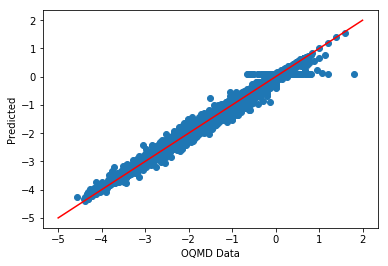

In [11]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,3), range(-5,3), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Compute mean absolute cross-validation error

In [12]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.087789870376
CPU times: user 2min 7s, sys: 880 ms, total: 2min 8s
Wall time: 2min 9s


## Predict formation energies of another set of ternary compounds

In [13]:
#Load prediction set and calculate attributes

prediction_set = pd.read_csv("datasets/meredig_prediction_set.csv", sep=" ")
comp_objects = [Composition(comp) for comp in prediction_set["composition"]]
prediction_set = prediction_set.assign(comp_obj=comp_objects)

ps_descriptors, ps_attr_names = calc_attributes(prediction_set)

ps_descriptors

,composition,current_knownFE,ML_stability,heuristic_stability,comp_obj,Ac,Ag,Al,Am,Ar,...,range Electronegativity,range Number,avg d valence electrons,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons
0,F5Si1Yb3,-2.315326,0.788656,1.104844,"(F, Yb, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.720,61.0,0.000000,4.666667,3.000000,2.000000,0.000000,0.482759,0.310345,0.206897
1,O4P1.33333333U1,-2.510609,0.989140,0.949985,"(O, U, P)",0.000000,0.0,0.0,0.0,0.0,...,2.060,84.0,0.157895,0.473684,3.157895,2.000000,0.027273,0.081818,0.545455,0.345455
2,O8Si1Pa5,-2.861381,0.720226,1.060872,"(O, Pa, Si)",0.000000,0.0,0.0,0.0,0.0,...,1.940,83.0,0.357143,0.714286,2.428571,2.000000,0.064935,0.129870,0.441558,0.363636
3,F5S1.5V1,-2.105698,0.770123,0.986644,"(S, F, V)",0.000000,0.0,0.0,0.0,0.0,...,2.350,14.0,0.400000,0.000000,4.133333,2.000000,0.061224,0.000000,0.632653,0.306122
4,F9V3Yb1,-2.665806,0.701196,1.028361,"(F, Yb, V)",0.000000,0.0,0.0,0.0,0.0,...,2.720,61.0,0.692308,1.076923,3.461538,2.000000,0.095745,0.148936,0.478723,0.276596
5,O4P1.33333333Pa1,-2.422391,1.124232,0.735729,"(O, Pa, P)",0.000000,0.0,0.0,0.0,0.0,...,1.940,83.0,0.157895,0.315789,3.157895,2.000000,0.028037,0.056075,0.560748,0.355140
6,F5S1.5Mn1,-1.763971,1.066721,0.738074,"(S, Mn, F)",0.000000,0.0,0.0,0.0,0.0,...,2.430,16.0,0.666667,0.000000,4.133333,2.000000,0.098039,0.000000,0.607843,0.294118
7,O2Si1U2,-2.202354,0.747492,0.823106,"(O, U, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.060,84.0,0.400000,1.200000,2.000000,2.000000,0.071429,0.214286,0.357143,0.357143
8,F2Si1Pa1.5,-2.098935,0.726589,0.829021,"(F, Pa, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.480,82.0,0.333333,0.666667,2.666667,2.000000,0.058824,0.117647,0.470588,0.352941
9,O2Si1Np2,-2.354734,0.725948,0.808873,"(O, Np, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.080,85.0,0.400000,1.600000,2.000000,2.000000,0.066667,0.266667,0.333333,0.333333


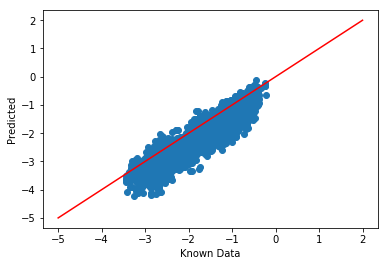

In [14]:
ps_prediction = rf_model.predict(ps_descriptors[attr_names])
plt.scatter(prediction_set["current_knownFE"], ps_prediction)
plt.plot(range(-5,3), range(-5,3), 'r')
plt.xlabel("Known Data")
plt.ylabel("Predicted")

In [15]:
mae = np.mean(np.abs(prediction_set["current_knownFE"] - ps_prediction))
print mae

0.409964011301
